# Rogun HPP - Surface DXF to Nodes in CSV

... revise for geological surfaces ...

This procedure prepares geological surface data from a CAD DXF and is intended to provide necessary input to the Hydropower Waterways Decision Support System (Waterways DSS), along with the Basemaps Setup module:
- alignments for feasibilty and siting analysis
- alignments for determing geolocation of project data and for visualizing this.

[Various means of using alignemnt data for hydropower and geotechnical analysis, which includes data analysis and visualization, have been reviewed:
1. export geometry from CAD (often Civil3d) using a suitable geospatial format and use python procedures for analysis: geojson(3d) would be ideal but is hot supported; LandXML is supported from Civil3d, but we found this to be complicated and fragile; DXF export is the time-proven fallback solution 
2. perform analysis inside of CAD (probably Civil3d), most probably as plug-in developed using C++ API: not a realistic scenario in most engineering consultancy offices
3. perform analysis from CAD ((probably Civil3d) using bindings to an external software development environment (pytprobably hon): solution does not yet exist and bindings to CAD/Civil3d are considered to have a steep learning curve.

The only practical choice at this time is 1.] (move this text to Notes)

The procedure described here is one of three procedrues foreseen for preparing alignment data for the Waterways DSS:
1. select alignment geometry from CAD (or e.g. Sketchup) and export as DXF, and process with grass and python for alignment definition
2. prepare alignment with surveying software (I am using Traverse PC), using alignment data from drawings and reports
3. digitize alignments from project layouts (e.g. as prepared by Basemap Setup) together with profile data, using QGIS, and export alignment as CSV (or alternatively query coordinates at tangent points along alignment and write into a CVS data file).

This procedure adresses in particular line data exported as DXF from Sketchup:
- "alignment" polyline data (main aim)
- wire mesh line data (just as a preliminary exploration).

The exported line data can in principle be either LINE or POLYLINE. My experience however is that Sketchup exports polylines as unordered LINE data, e.g. the exported polyline segments are not in topological order. It may be possible to group or weld lines to form a polyline (plug-in?) in Sketchup, but this would need to be robust in all edge cases. It seems easier to just allow for unordered line data as input to grass and to order the line data with grass.

Wire mesh data is processed with grass to LINESTRINGS, which remain as topologically unordered line segments. As the purpose of wire mesh data is only for visulaization of structures, unordered line segments will be suitable.

"Alignment" polyline data exported from Sketchup as unordered LINE data must be processed to produce an ordered sequence of vertices along the alignment polyline. This works explores processing the "alignment" polyline data in grass.

In [1]:
# ToDo
#   all data (e.g. file names) as variables
#   markdown titles
#   comments with explanations
#   this example use grass script, do again with pygrass defining class & methods (to go into API later)


## grass setup

In [2]:
# set up Python for GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image

# set up GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
os.environ['GRASS_FONT'] = 'sans'
os.environ['GRASS_OVERWRITE'] = '1'  #overwrite existing maps
sys.path.append(os.path.join(gisbase, "etc", "python"))

# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

# import GRASS GIS
import grass.script as gs
import grass.script.setup as gsetup
from grass.script import core as grass

# for pygrass
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

from subprocess import PIPE

# further setup for GRASS GIS 
gs.set_raise_on_error(True)
#gs.set_capture_stderr(True)  #might be Python 2 vs 3 issue (unsure if Python 3 required for this Notebook)

False

In [3]:
# https://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library
# GRASS Python Scripting Library
# How to retrieve error messages from read_command():

def read2_command(*args, **kwargs):                                                 #rename to e.g. read_grass
   kwargs['stdout'] = grass.PIPE
   kwargs['stderr'] = grass.PIPE
   ps = grass.start_command(*args, **kwargs)
   return ps.communicate()

In [4]:
# create a mapset (mapset does not already exist)
# should only do once (but will report error and exit if already exists)

# dir /home/kaelin_joseph/projects/RogunHEP/grassdata  should already exist
!grass -c EPSG:3857 /home/kaelin_joseph/projects/RogunHPP/grassdata/RogunHPP -e
# should use grass scipt                                                                             ToDo JK !!    

# define all parameters separately                                                                   ToDo JK !!
#EPSG:3857  #WGS84 Pseudo Mercator

Cleaning up temporary files...
Creating new GRASS GIS location/mapset...
ERROR: Failed to create new location. The location <RogunHPP> already exists.
Exiting...


In [5]:
# open mapset
rcfile = gsetup.init(gisbase, 
         "/home/kaelin_joseph/projects/RogunHPP/grassdata",
         "RogunHPP/", "PERMANENT")

In [6]:
# check grass env
print grass.gisenv()

{'MAPSET': 'PERMANENT', 'GISDBASE': '/home/kaelin_joseph/projects/RogunHPP/grassdata', 'LOCATION_NAME': 'RogunHPP/'}


In [7]:
# check projection info
read2_command('g.proj', flags = 'jf')

('+proj=merc +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +no_defs +a=6378137 +rf=298.257223563 +towgs84=0.000,0.000,0.000 +to_meter=1\n',
 '')

In [8]:
#check mapsets
grass.mapsets()

['PERMANENT']

In [9]:
# set grass region for project
n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog
g.region(n=n,s=s,e=e,w=w, res=5)

Module('g.region')

In [10]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      24797
south:      20796
west:       25597
east:       28600
nsres:      5.00125
ewres:      4.99667221
rows:       800
cols:       601
cells:      480800



In [11]:
# # define geological surface to be processed
# surface = '/home/kaelin_joseph/projects/RogunHPP/data/in/fault_3.dxf'

# define geological layers to be processed
layers = [3, 5]
surfaces, surfaces_vect = [], []
surfaces_points, surfaces_points_csv = [], []

for layer in layers:
    surfaces.append('/home/kaelin_joseph/projects/RogunHPP/data/in/layer_'+str(layer)+'.dxf')
    surfaces_vect.append('surface_'+str(layer))
    surfaces_points.append('surface_points_'+str(layer))
    surfaces_points_csv.append('/home/kaelin_joseph/projects/RogunHPP/data/out/layer_'+str(layer)+'.csv')
    
# define required output data files for project
# refactor to provide names for each specific layer using string addition                           #ToDo jjk
# surface_vect = 'surface'
# surface_points = 'surface_points'
# surface_points_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/Surface_points.csv'

In [12]:
surfaces_points

['surface_points_3', 'surface_points_5']

## import DXF data to grass vector (lines)

In [13]:
# read dxf data
n = 0

for surface in surfaces:
    read2_command("v.in.dxf", input=surface, 
             output=surfaces_vect[n], flags='e')[0]
    n = +1
                                 
#read2_command("v.in.dxf")
# pattern for 'printing grass output nicely
#   decode must be applied to each member of tuple
#   [0] -> stdout
#   [1] -> stderr
#   above are according to doc, however it seems that [1] is where all output is                  ToDo JK:  ??

In [14]:
# set grass region from vector data bounds
read2_command('g.region', vector=surfaces_vect[0])

('', '')

In [15]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      23584.76757812
south:      22743.34960938
west:       27033.38476562
east:       27826.00390625
nsres:      5.00844029
ewres:      4.98502604
rows:       168
cols:       159
cells:      26712



In [16]:
def report_vect(surface_vect):
# report of vector data imported from dxf
#  comment out individual reporting as desired

    # report imported DXF layers
    print(read2_command("v.info", map=surface_vect, layer='-1', verbose=True)[0].decode()) 

#     # report entities in imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.db.select", map=surface_vect)[0].splitlines()
#     for line in range(0,4):
#         print(out[line])

#     # report categories in imported DXF layers
#     print('\n')
#     print(read2_command("v.category", input=surface_vect, layer='-1', option='report', verbose=True)[0].decode()) 

#     # report coordinatesin imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.report", map=surface_vect, layer='-1', option='coor', verbose=True)[0].splitlines()
#     for line in range(0,1):
#         print(out[line])

#     # report on attributes stored in grass sqlite database
#     print('\n')
#     print(read2_command("v.db.connect", map=surface_vect, flags='c', verbose=True)[0].decode()) 
    
for surface_vect in surfaces_vect:
    report_vect(surface_vect)

 +----------------------------------------------------------------------------+
 | Name:            surface_3                                                 |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           surface_3                                                 |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [17]:
# view and check imported topography
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=surfaces_vect[1], color='green')

('', 'd.vect complete.\n')

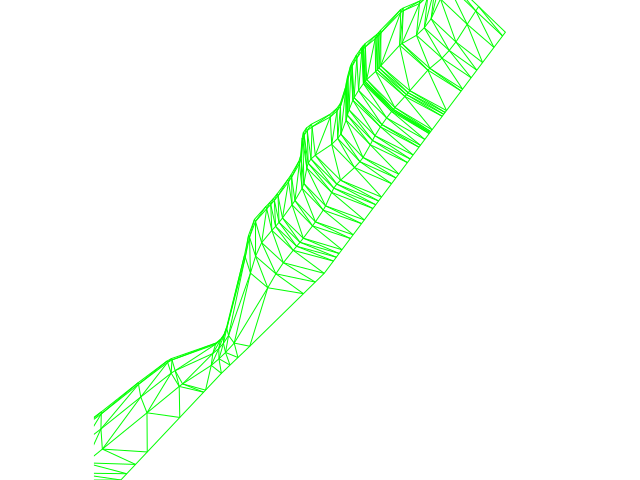

In [18]:
Image(filename="map.png")

## extract points (unordered) from imported DXF vector data

In [19]:
def output_points(surface_vect, surface_points):
    points_out = read2_command("v.to.points", input=surface_vect, output=surface_points) 
    print(points_out[1].decode())

n = 0
for surface_vect in surfaces_vect:
    output_points(surface_vect, surfaces_points[n])
    n = +1    

         overwritten
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Building topology for vector map <surface_points_3@PERMANENT>...
Registering primitives...
993 primitives registered
993 vertices registered
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
Number of nodes: 0
Number of primitives: 993
Number of points: 993
Number of lines: 0
Number of boundaries: 0
Number of centroids: 0
Number of areas: 0
Number of isles: 0
v.to.points complete. 993 poin

In [20]:
# view and check points topography
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=surfaces_points[1], color='red')

('', 'd.vect complete.\n')

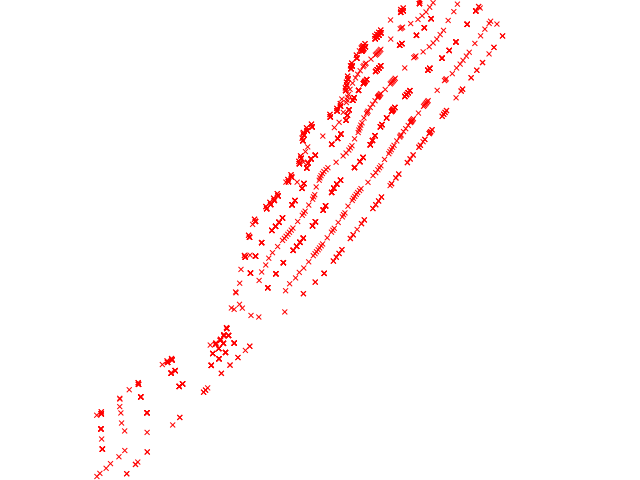

In [21]:
Image(filename="map.png")

## write points to CSV data file

In [22]:
#!g.region -p3


In [23]:
# zoom grass region to area of surface of interest
# this is done primarily to minimize edge artifacts (ill-formed top edge) of a plotly mesh surface

#n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog

# determine bounds by inspection of plot result
#n,s,e,w = 23500, 20796, 28600, 27400
n,s,e,w = 23500, 22743, 27800, 27400
g.region(n=n,s=s,e=e,w=w, res=10)     #res=5)

Module('g.region')

In [24]:
#!v.out.ascii  --help

In [25]:
# write points extracted from imported DXF data to csv file
def write_points(surface_points, surface_points_csv):
    points_out = read2_command("v.out.ascii", input=surface_points, type='point', separator=',',
                       layer=-1, output=surface_points_csv, flags='r') 
    print(points_out[1].decode())

n = 0
for surface_points in surfaces_points:
    write_points(surface_points, surfaces_points_csv[n])
    n = +1    

In [26]:
#!head -5 /home/kaelin_joseph/projects/RogunHPP/data/out/Surface_points.csv
from __future__ import print_function
file = surfaces_points_csv[1]
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

27436.99023438,23105.59765625,859.88873291
27400.02372452,23350.05426121,1177.98021179
27467.88718788,23411.14886217,1184.1741987
27498.77153206,23495.71218862,1174.71964325
27494.80093206,23182.53415454,845.36215782


## rasterize vector surfaces

In [27]:
def read_grass(*args, **kwargs):                                                                      
    """execute a grass function with error output """                                                       
    kwargs['stdout'] = grass.PIPE                                                                           
    kwargs['stderr'] = grass.PIPE                                                                           
    ps = grass.start_command(*args, **kwargs)                                                               
    # returns a tuple (stderr,stdout)                                                                       
    return ps.communicate()    

def rasterize_vect_using_points(npoints=12, power=2, dbg=1):                                          
    """convert vector topograpy using extracted points to raster dem"""                                     

    # convert vect to raster DEM using v.surf.idw (inverse distance weighting interpolation)   
    out = read_grass("v.surf.idw", input='surface_points_5',    #input=surfaces_points[1],                                          
                     layer='-1', output='surfaces_rast', npoints=npoints, power=power)             
    print(out[dbg].decode())                                                                                
    print('rasterize_vect_using_points completed')    

# for testing    
def rasterize_vect_using_points_2(dbg=1):                                          
    """convert vector topograpy using extracted points to raster dem"""                                     

    # convert vect to raster DEM using v.surf.idw (inverse distance weighting interpolation)   
    out = read_grass("v.surf.rst", input='surface_points_5',    #input=surfaces_points[1],                                          
                     layer='-1', elevation='surfaces_rast_', dmin=0.5, mask='MASK')             
    print(out[dbg].decode())                                                                                
    print('rasterize_vect_using_points completed')         

In [28]:
# define raster mask based on vector data bounds
!r.mask vector=surface_5

WARNING: No area found in vector map <surface_5@PERMANENT>. Creating a
         convex hull for MASK.
Reading areas...
   0 100
Reading features...
  50 100
Writing raster map...
   0   3   6   9  13  17  21  25  28  31  34  38  42  46  50  53  56  59  63  67  71  75  78  81  84  88  92  96 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.


In [29]:
rasterize_vect_using_points()  # mask is not applied by v.surf.idw"
                               # d.mon does not display, grass bug?
#rasterize_vect_using_points_2()  #testing

Input vector map <surface_points_5@PERMANENT> is 3D - using z-coordinates
to interpolate
730 points loaded
Interpolating raster map <surfaces_rast> (76 rows, 40 columns)...
   0%   2%   5%   7%   9%  11%  13%  15%  17%  19%  21%  23%  25%  27%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  55%  57%  59%  61%  63%  65%  67%  69%  71%  73%  75%  77%  80%  82%  84%  86%  88%  90%  92%  94%  96%  98% 100%
v.surf.idw complete.

rasterize_vect_using_points completed


In [30]:
# resmaple applying mask 
out = read_grass("r.resamp.rst", input='surfaces_rast',                                     
                 elevation='surfaces_rast_', ew_res=10, ns_res=10)             
print(out[1].decode())                                                                                


Processing all selected output files will require
11.88 KB of disk space for temp files.
Temporarily changing the region to desired resolution ...
Bitmap mask created
Changing back to the original region ...
Percent complete:
   0%   3%   6%   9%  12%  14%  17%  20%  23%  25%  28%  31%  34%  37%  39%  42%  45%  48%  50%  53%  56%  59%  62%  64%  67%  70%  73%  75%  78%  81%  84%  87%  89%  92%  95%  98% 100%
dnorm in ressegm after grid before out2= 128.198551 
dnorm in mainc after grid before out1= 128.198551
dnorm in mainc after grid before out2= 128.198551
r.resamp.rst complete.



In [31]:
print(read_grass("r.info", map='surfaces_rast_')[0].decode())
print(read_grass("r.report", map='surfaces_rast_', units='h,p', nsteps=10)[0].decode()) 
print(read_grass("r.univar", map='surfaces_rast_')[0].decode()) 

 +----------------------------------------------------------------------------+
 | Map:      surfaces_rast_                 Date: Sun Oct 14 18:24:38 2018    |
 | Mapset:   PERMANENT                      Login of Creator: kaelin_joseph   |
 | Location: RogunHPP/                                                        |
 | DataBase: /home/kaelin_joseph/projects/RogunHPP/grassdata                  |
 | Title:     ( surfaces_rast_ )                                              |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                                                      |
 |   Rows:         76                                                         |
 |   Columns:      40                   

         Your current region setting may be too large. Cells displayed on
         your graphics window may be too small for cell category number to
         be visible.
WARNING: MONITOR variable defined, GRASS_RENDER_IMMEDIATE ignored
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600


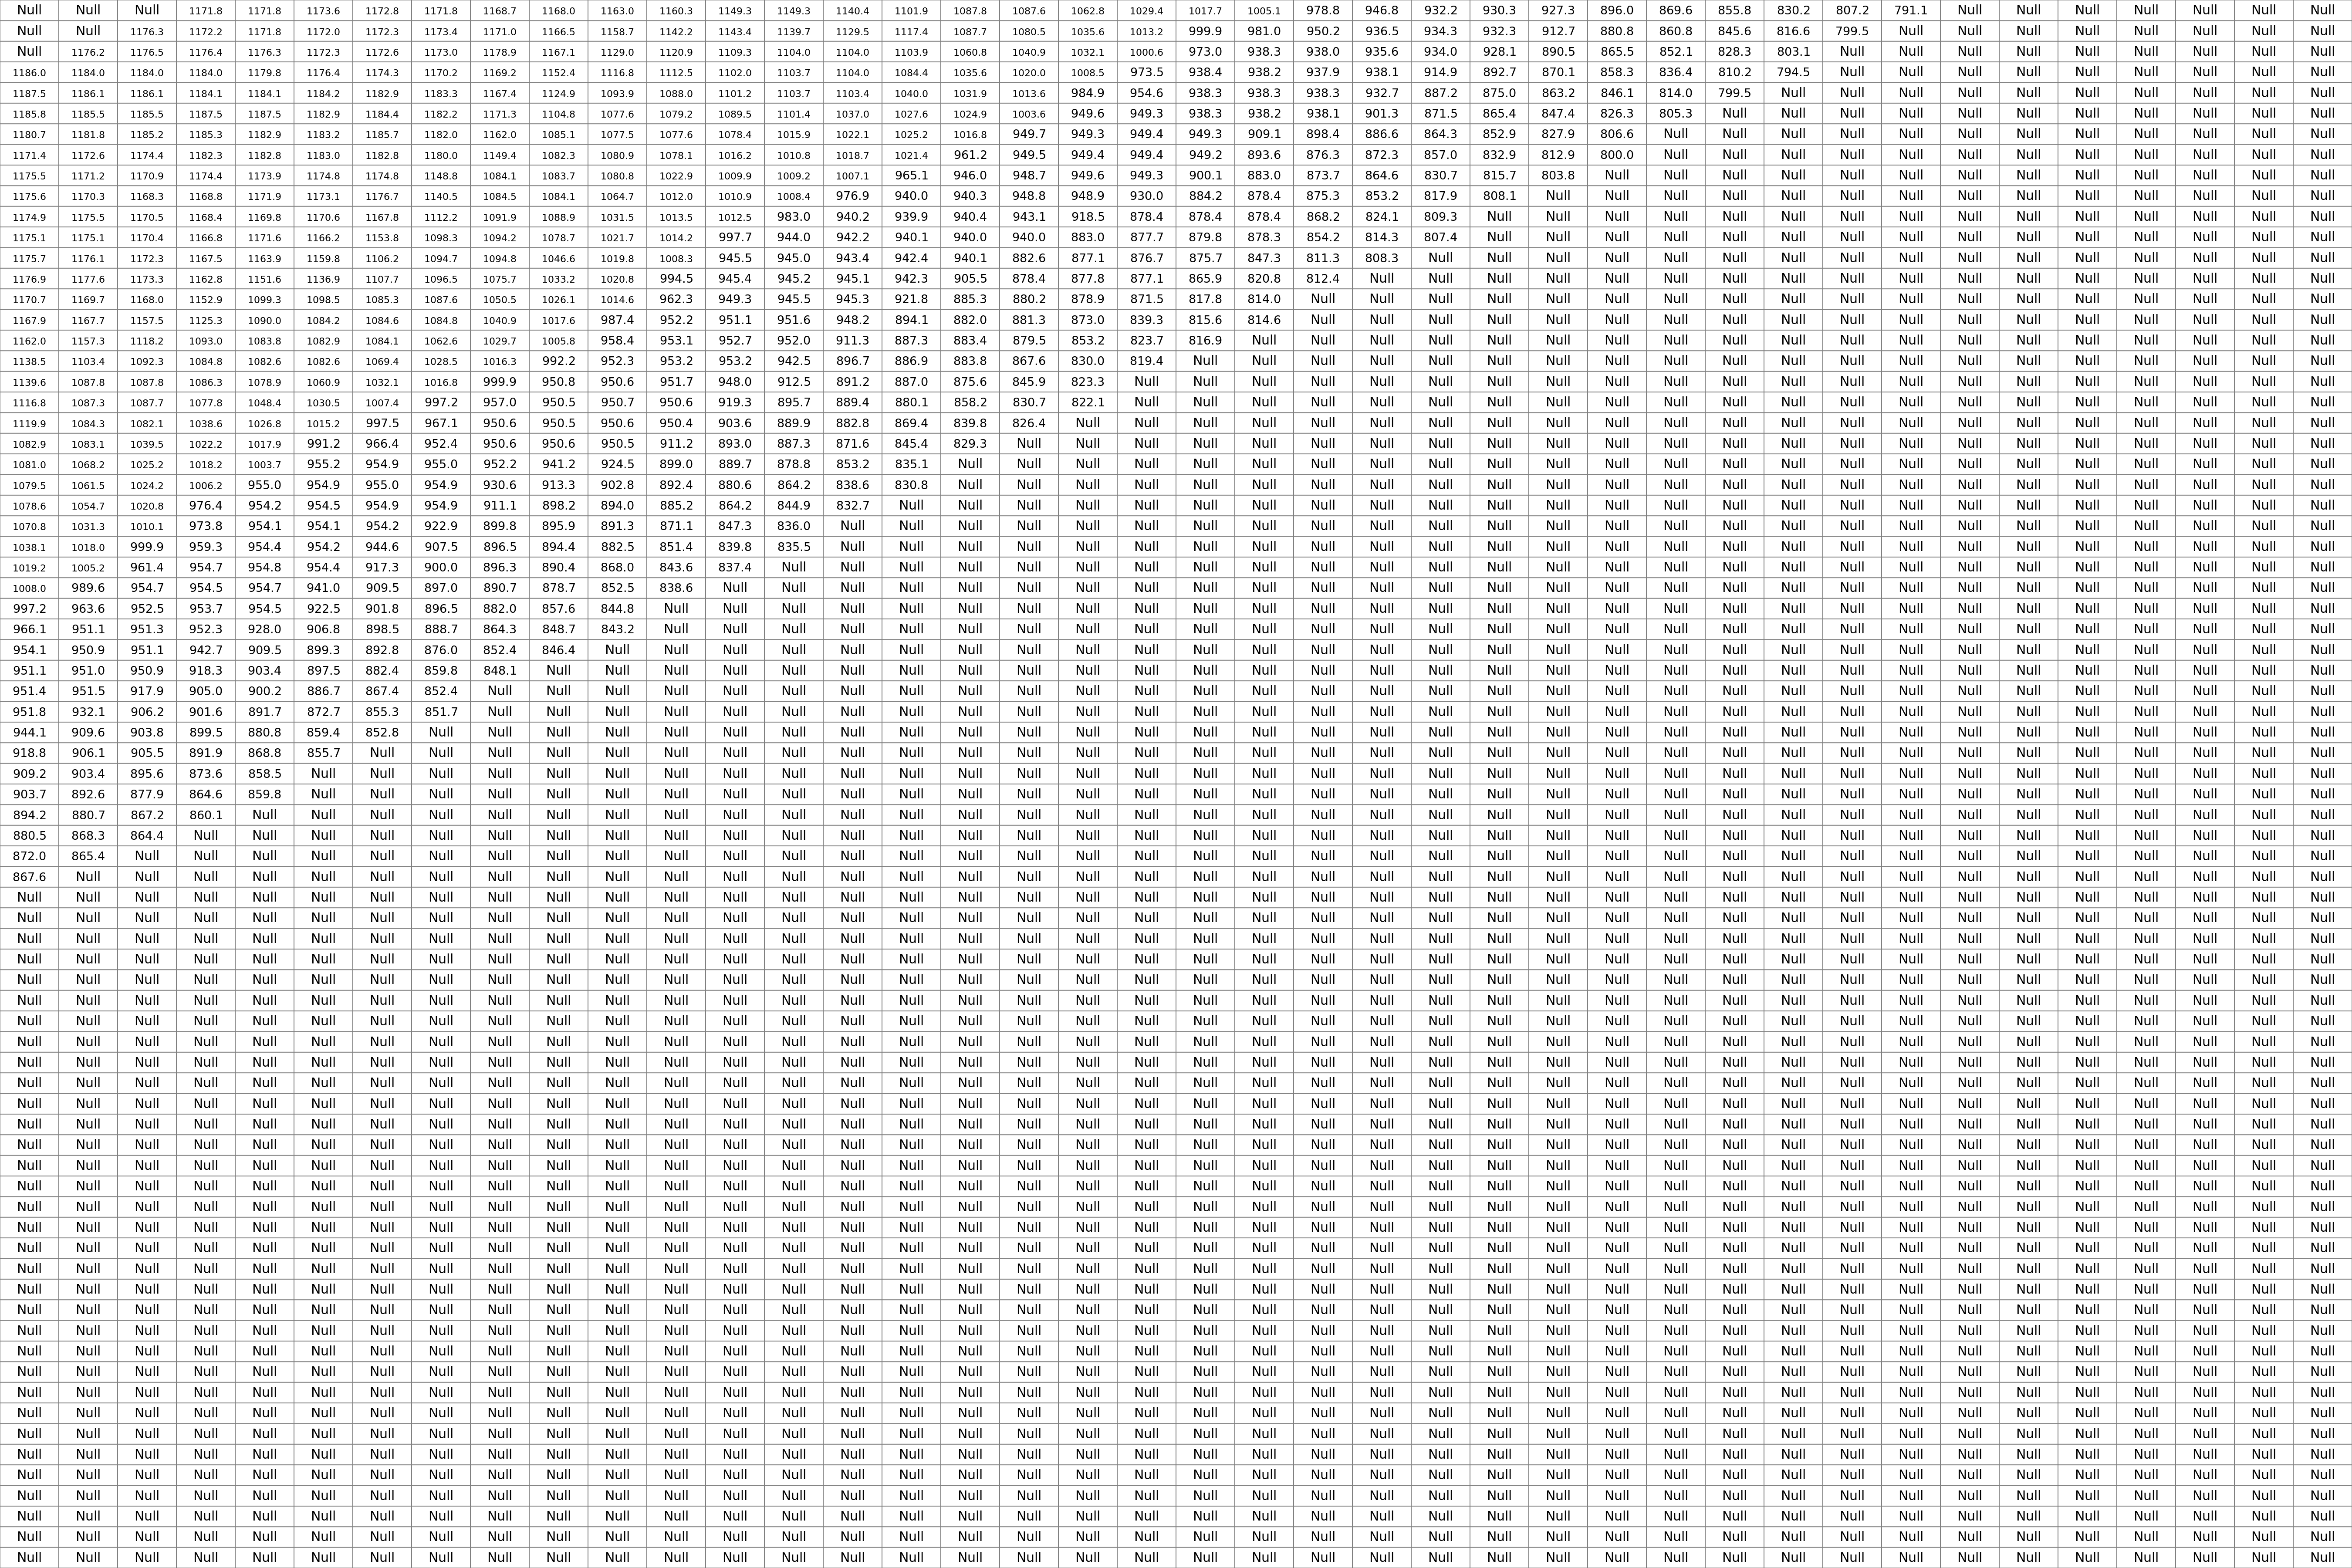

In [32]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)  #outputs, is blank
# read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True, 
#            output='map.pdf')  #outputs, but is blank

#read_grass("d.rast", map='surfaces_rast', bgcolor='white', flags='n')
#read2_command("d.rast", map='surfaces_rast')

# for troubleshooting
#https://grass.osgeo.org/grass77/manuals/d.rast.num.html
!d.rast.num surfaces_rast_ --verbose -a  #values look ok (except raster area outside of surface is not null)
####!d.rast.num surface_5 --verbose -a
#!d.rast.leg surfaces_rast --verbose

# show legend and grid, display result
#read_grass("d.legend", raster='surfaces_rast', fontsize='24')[1]
#read_grass("d.grid", size=1000, fontsize=20)[0]
Image(filename="map.png")

In [33]:
!rm map.png                                                                                 #ToDo JK: pythonize
##read2_command("d.rast", map='surfaces_rast_', verbose=True)   #output, but is blank, seems to be PNG issue
#read2_command("d.rast", map='topog_rast_resamp', verbose=True)   #ok

#!d.rast surfaces_rast_ --verbose 
!d.rast.leg surfaces_rast_ --verbose


Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600
Reading <surfaces_rast_> ...
   0   3   6   9  13  17  21  25  28  31  34  38  42  46  50  53  56  59  63  67  71  75  78  81  84  88  92  96 100
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600
   0   3   6   9  13  17  21  25  28  31  34  38  42  

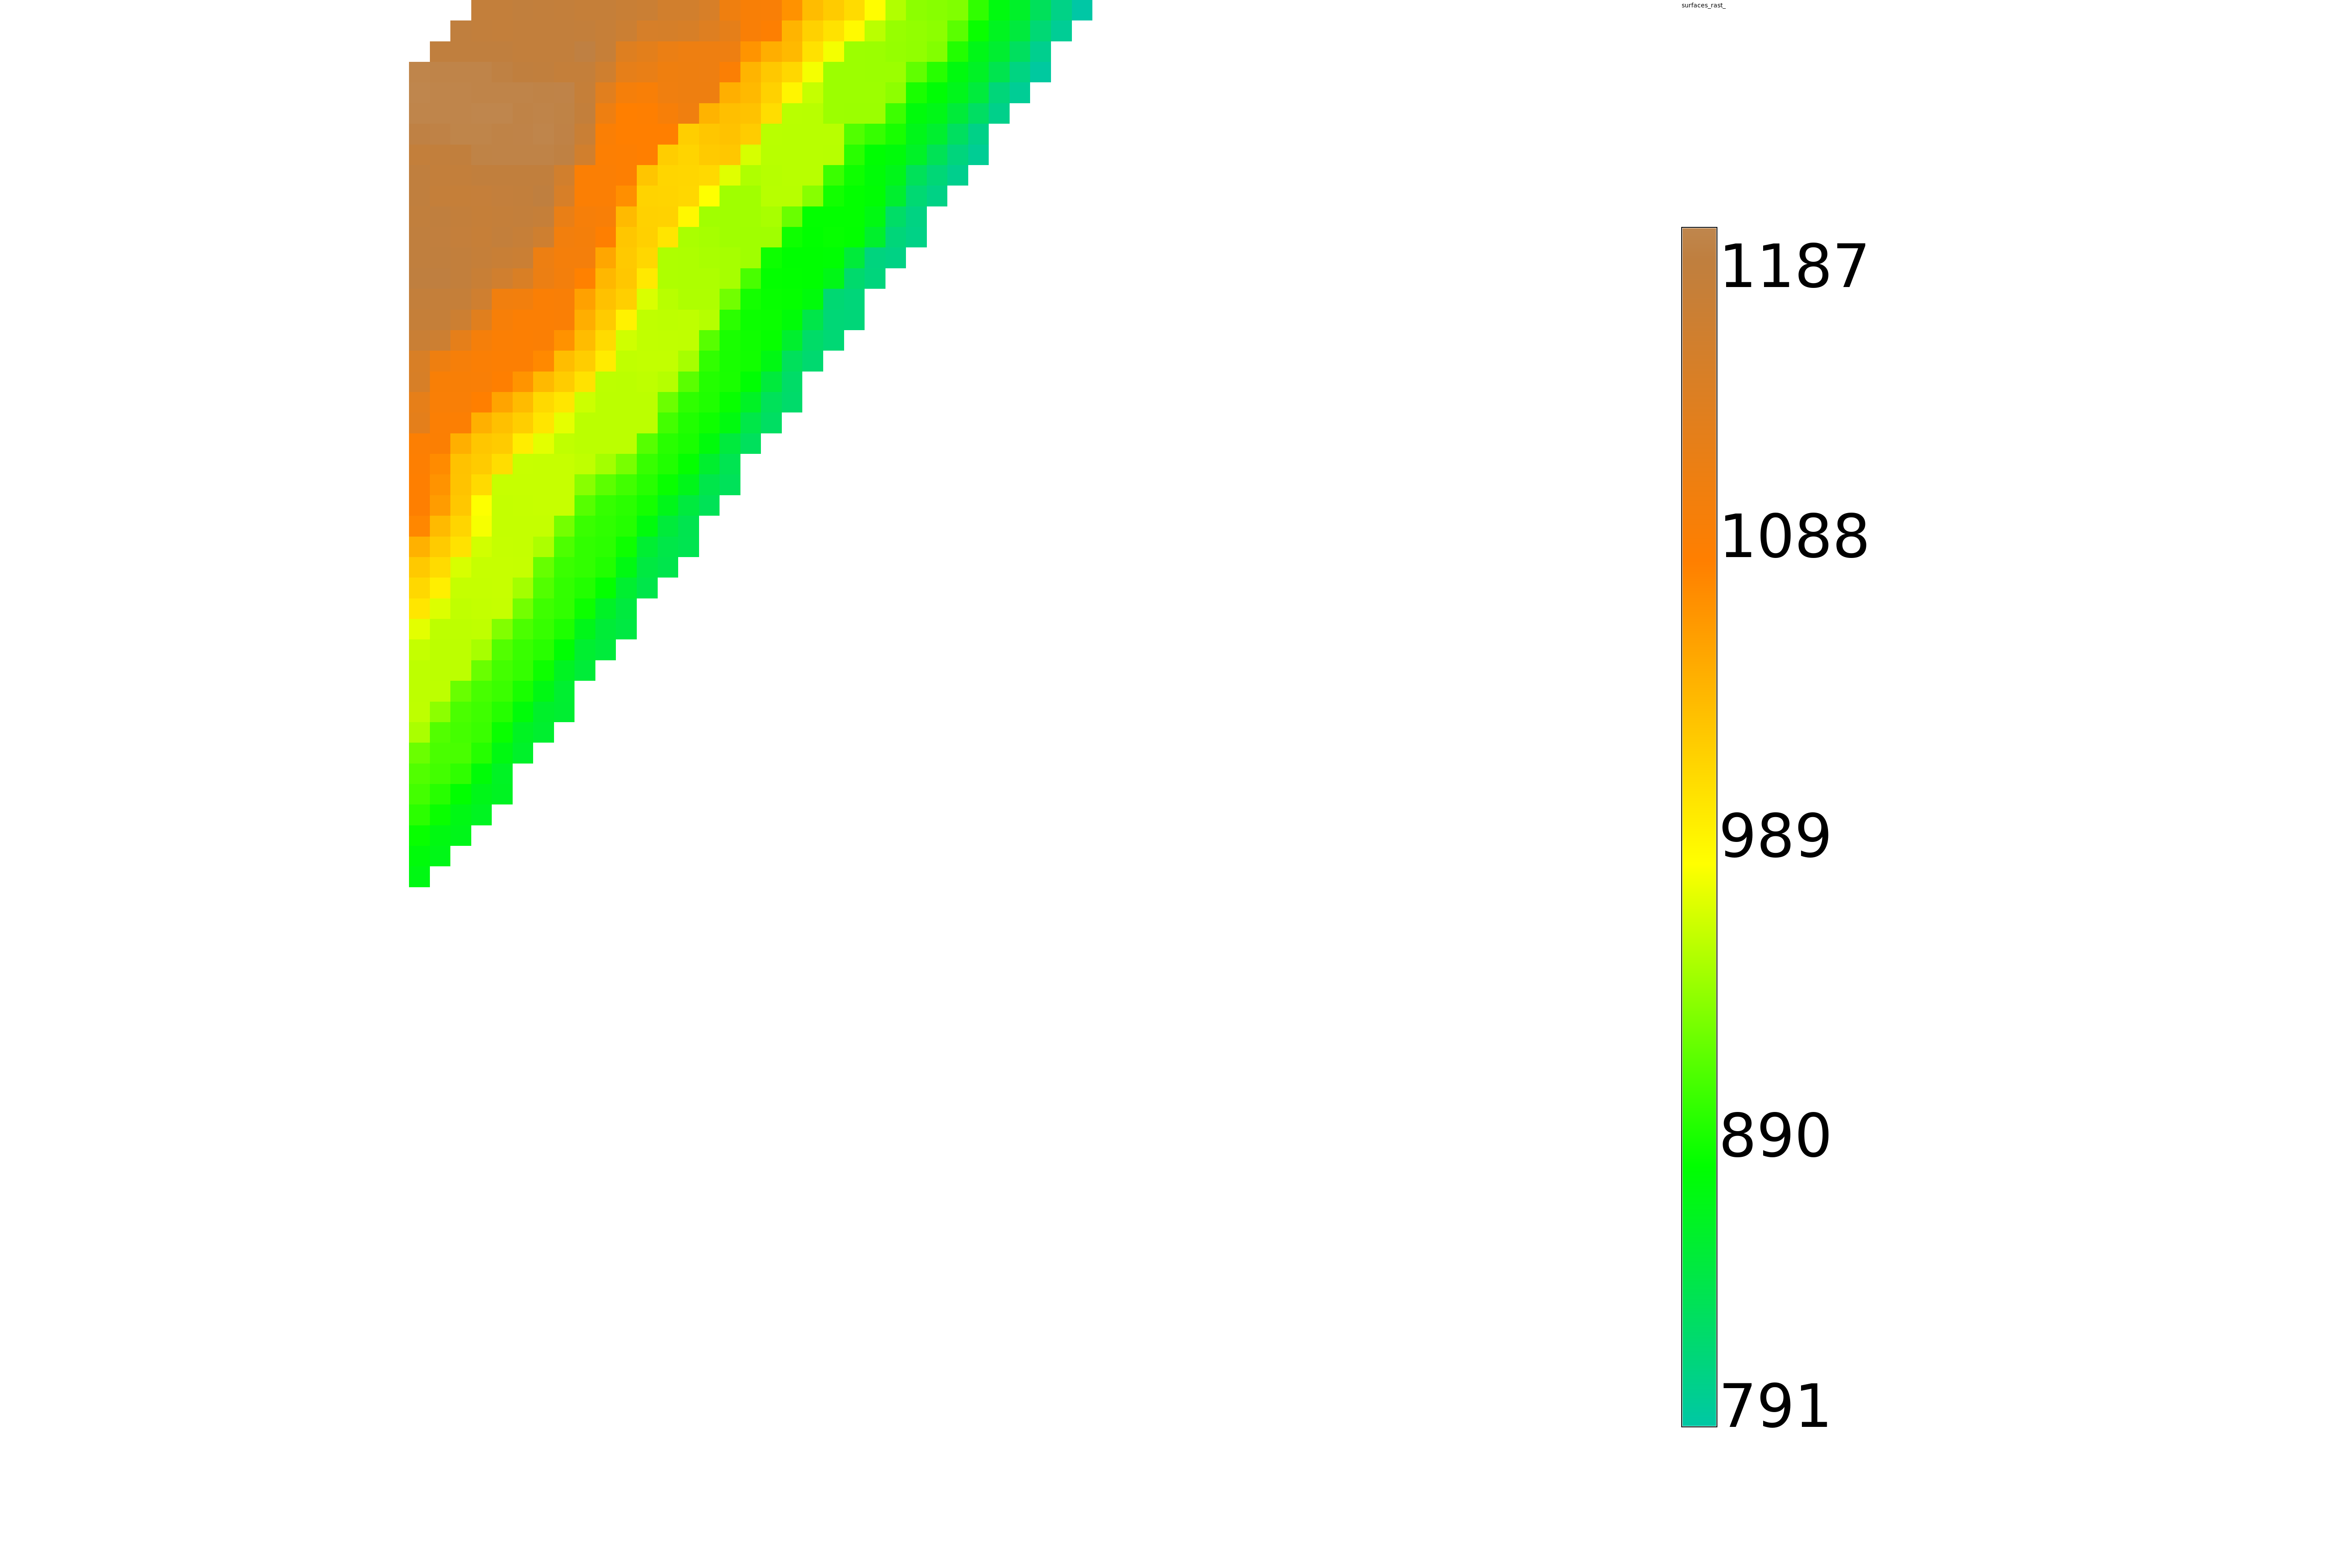

In [34]:
Image(filename="map.png")

In [35]:
!r.what map=surfaces_rast_ coordinates=27490.6,23387.1  ##works

27490.6|23387.1||1078.695


In [36]:
#!r.out.gdal input=surfaces_rast output=surfaces_rast.png format=PNG  #error with libpng
!r.out.gdal input=surfaces_rast output=surfaces_rast.tif  #output file seems ok & mask is applied

Checking GDAL data type and nodata value...
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
r.out.gdal complete. File <surfaces_rast.tif> created

In [37]:
!file surfaces_rast.tif


surfaces_rast.tif: TIFF image data, little-endian, direntries=18, height=76, bps=64, compression=none, PhotometricIntepretation=BlackIsZero, width=40
